 # Utviklingsstatistikk

[Formål](#formål)

[Utfordring med å måle sikker og stabil drift](#utfordring)

[Måleparametere](#måleparametere)

[Om systemet](#omsystemet)

[Målinger](#målinger)

* [Kodestørrelse](#kodestørrelse)
* [Kodeendringer](#kodeendringer)
* [Netto vekst i kodelinjer](#nettovekst)
* [Detaljer i netto vekst i kodelinjer](#nettovekstdetaljer)
* [Oppdatering av avhengigheter](#oppdateringavhengigheter)
* [Løpende endringer i systemet](#løpendeendringer)
* [Risiko](#risiko)

[Konklusjoner](#konklusjoner)

# Formål <a class="anchor" id="formål"></a>

Teamet har blitt bedt om å måle på noe som kan indikere om vi har sikker og stabil drift.

# Utfordring med å måle sikker og stabil drift  <a class="anchor" id="utfordring"></a>

Utfordringen med tradisjonell måling av sikker og stabil drift er at den gjerne måler på ting som oppetid eller rettetid. Dette er målinger som først slår ut etter at driften ikke lenger er sikker og/eller stabil, og det kan ta lang tid fra driften faktisk har blitt problematisk til målingene slår ut.

Vår erfaring er at risiko øker når systemer ikke holdes vedlike. Risiko påvirkes av manglende vedlikehold gjennom flere prosesser:
1)	Manglende oppdatering av avhengigheter gir økt sikkerhetsrisiko
2)	Manglende teknisk oppdatering gir økt sikkerhetsrisiko og risiko for lav kjennskap til utdaterte tekniske løsninger
3)	Lite andre endringer reduserer kunnskapen om systemet som øker rettetid og øker sjansen for feil når man en sjelden gang gjør enderinger

Vi mener det er verdt å forsøke å måle på utviklingsprosessen for å se om det kan gi indikatorer som sier noe om risikobildet.

Siden det er kostnader ved å gjøre målinger har vi sett etter målinger som er forholdsvis lette å innhente og som kan gi en indikasjon på at systemet vedlikeholdes.


# Måleparametere  <a class="anchor" id="måleparametere"></a>

Teamet tok sommeren 2022 i bruk teknikkene micro-commits og Arlo’s commit notation – dette gjør det mulig å benytte commit-statistikk til å si noe om omfang, intensjon og risiko ved commit’er.

Teamet har besluttet å se om
•	tellinger og forholdstall på ulike typer commits og
•	måling på kodestørrelse
kan indikere hvordan utviklingen er – og predikere eller illustrere en situasjon der det vil oppstå økt risiko for ustabil / usikker drift.

In [1]:
# Setter ROOT_DIR
import os, sys
ROOT_DIR = os.path.dirname(os.path.abspath("")) if os.path.basename(os.path.abspath("")) != "eessi-pensjon" else os.path.abspath("")
os.chdir(ROOT_DIR)
sys.path.append(f'${ROOT_DIR}/script')

In [2]:
# Henter inn commit-data
from datetime import datetime
from script.lib.commit_data import gather_changes_from_subprojects

startdate = datetime(2022, 1, 1)

commits_dict = gather_changes_from_subprojects(ROOT_DIR, datetime.now() - startdate)

In [3]:
# Pass på at vi har pandas
!pip install pandas 2>&1 1>/dev/null

In [4]:
# Konverter data til Pandas dataframe
import pandas as pd
import numpy as np

df = pd.DataFrame(commits_dict)

# Fiks datoformat fra python til pandas (og samme tidssone)
df['timestamp'] = df['timestamp'].apply(lambda x: pd.to_datetime(x).tz_convert('Europe/Berlin'))
df['risk'] = pd.to_numeric(df['risk'])
df['commit'] = df['hash']

# Legg på måned og tertial

df['Måned'] = pd.PeriodIndex(df['timestamp'], freq='M')
df['Tertial'] = df["timestamp"].apply(lambda x: f"{x.year}T{int((x.month - 1) / 4) + 1}")
# Legger til noen kjekke kolonner
df['BDFRT'] = np.where(df['intention'].isin(['B', 'D', 'F', 'R', 'T']), True, False)
df['UE'] = np.where(df['intention'].isin(['U', 'E']), True, False)

# Mer lesbar intention
conditions = [df['intention'] == 'E', df['intention'] == 'A', df['intention'] == 'P',
              df['intention'] == 'U', df['intention'] == 'F', df['intention'] == 'R',
              df['intention'] == 'D', df['intention'] == 'T', df['intention'] == 'B',
              df['intention'] == '*']
choices = ['E Miljø', 'A Automatisert', 'P Release (bibliotek)', 'U Avhengighet',
           'F Funksjonalitet', 'R Refaktorering', 'D Dokumentasjon', 'T Test',
           'B Feilretting', '* Uklassifisert']
df['Intention'] = np.select(conditions, choices, np.nan)

# Mer lesbar risk
conditions = [df['risk'] == 0, df['risk'] == 1, df['risk'] == 2, df['risk'] == 3,
              df['risk'] == 4, df['risk'] == 5, pd.isnull(df['risk'])]
choices = ['0 Ingen risiko', '1 Kjent trygg', '2 Validert', '3 Kjent restrisiko',
           '4 Feil/sannsynlig feil', '5 Ukjent risiko', np.nan]
df['Risk'] = np.select(conditions, choices, default=np.nan)

df['Kjent intention/risiko'] = np.where(df['intention'] != '*', True, False)

df_commits = df

In [5]:
# Henter inn størrelsedata
from script.lib.size_data import size_data, change_data

size_dict = size_data()

In [6]:
df = pd.DataFrame(size_dict)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
for col in ['files', 'blank lines', 'comment lines', 'code lines']:
    df[col] = df[col].astype(int)

df_size = df

In [7]:
 # Henter inn endring i størrelse-data

tertial = "2022T3"
changes_dict = change_data(tertial)

df = pd.DataFrame(changes_dict)

# Konverter "tall" til tall
for col in df.columns[df.columns.get_loc('== files'):]:
    df[col] = df[col].astype(int)

df_changes = df

In [8]:
!pip install matplotlib 2>&1 1>/dev/null

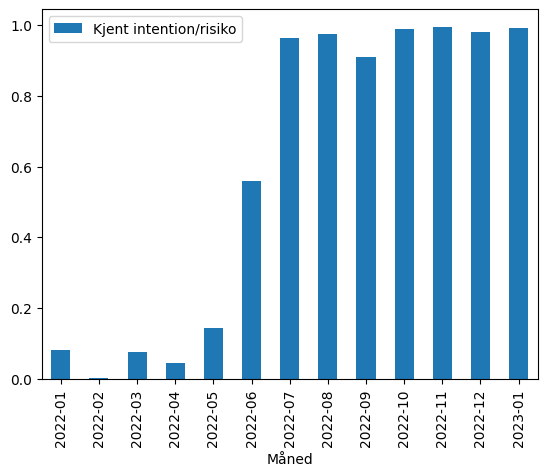

In [9]:
df = df_commits

df = df[['Måned', 'Kjent intention/risiko']]

df = df.groupby(df['Måned']).mean()
fig = df.plot(kind='bar')


Grafen viser at det fra juli 2022 har vært høy andel commits med angivelse av intensjon og risiko, og derfor egner seg til å gjøre analyse. Siden vi normalt rapporterer på tertialnivå så baserer vi oss i resten av rapporten på tiden fra og med 3. tertial 2022 (2022T3).

# Om systemet <a class="anchor" id="omsystemet"></a>

Systemet består av en frontendapplikasjon (saksbehandling-ui), 10 backendapplikasjoner, 7 delte bibliotek på backend og et antall bibliotek på frontend (som foreløpig ikke er med i oversikten og statistikken).

|Applikasjoner||
|---|---|
|saksbehandling-ui|Frontend for saksbehandlere|
|oppgave|Oppgaver til Oppgave (asynkron)|
|krav-initialisering|Krav til Pesys (asynkron)|
|statistikk|Statistikk til Statistikk-folket (asynkron)|
|onprem-proxy|For å kalle fra GCP til/fra onprem (Pesys mm) (online)|
|saksbehandling-api|Fasade for diverse API for saksbehandling-ui (online)|
|begrens-innsyn|Merking av saker med beskyttelse (asynkron)|
|journalforing|Journalføring av dokumenter (asynkron)|
|prefill|Preutfylling av SED (online)|
|fagmodul|Diverse API for saksbehandling-ui m fl (online)|
|pdl-produsent|Oppdatering av PDL med id’er og adresser (asynkron)|

| Bibliotek              ||
|------------------------|---|
| ep-metrics             |Metrikk-bibliotek|
| ep-eux                 |Domene-modell SED/BUC mm|
| ep-logging             |Loggingsbibliotek|
| ep-personoppslag       |Klient for oppslag mot PDL|
| ep-security-sts        |Brukes onprem for token-utveksling|
| ep-pensjonsinformasjon |Klient for oppslag mot Pesys|
| ep-kodeverk            |Klient mm - opplag i kodeverk|

| Meta                   ||
| ---                    |---|
| Meta                   |Verktøy for å jobbe på tvers av modulene nevnt ovenfor|



# Målinger <a class="anchor" id="målinger"></a>

## Kodestørrelse <a class="anchor" id="kodestørrelse"></a>

Kodestørrelse i applikasjoner korrelerer godt med kompleksitet, som igjen korrelerer med feil- og vedlikeholdsomfang.

Vi teller kodelinjer med cloc[^1]. (Det er noen små frontend-bibliotek som deles mellom EESSI NAV og EESSI Pensjon som ikke er med i statistikken).

### Kodestørrelse

In [10]:
print(f"Kodestørrelse pr {df_size['date'].dt.strftime('%d.%m.%Y')[0]}.")

Kodestørrelse pr 06.01.2023.


In [11]:
df = df_size[['language', 'files', 'code lines', 'comment lines']]
df.groupby('language').sum().sort_values(by='code lines', ascending=False)

,files,code lines,comment lines
language,,,
Kotlin,750,62691,2333
TypeScript,370,44195,1050
YAML,142,5456,56
Text,14,5388,0
Gradle,59,2844,161
Markdown,36,1523,0
LESS,21,1028,50
GraphQL,9,946,71
JavaScript,10,337,60


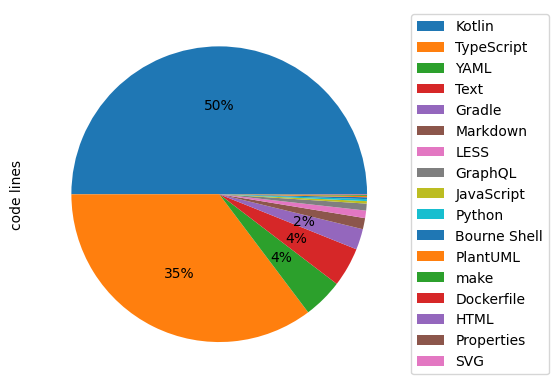

In [12]:
df = df_size[['language', 'code lines']]
df = df.groupby('language').sum().sort_values('code lines', ascending=False)

def autopct(pct): # only show the label when it's > 2%
    return ('%.0f' % pct + '%') if pct > 2 else ''

plt = df.plot.pie(y='code lines', autopct=autopct, labeldistance=None).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Koden er stort sett skrevet i Kotlin og TypeScript, og noe LESS– øvrig kode er knyttet til bygg, deploy, konfigurasjon og diverse utviklings- og støtteverktøy.


[^1]: Mer om cloc-kommandoen:
```
cloc --csv --vcs git --exclude-dir=dist,build,gradle --exclude-list-file=.clocignore --exclude-lang=JSON,XML --quiet .
```
der .clocignore inneholder:
```
gradlew
gradlew.bat
public/pdf.worker.js
public/static/js/pdf.worker.js
package-lock.json
src/components/PostalCodes/Postal-codes-Norway-ansi.ts
src/minibootstrap.less
```

In [13]:
df = df_size[['module', 'code lines']]
df = df.groupby('module').sum().sort_values(by='code lines', ascending=False)
df['code lines %'] = df['code lines'] / df['code lines'].sum() * 100
df

,code lines,code lines %
module,,
saksbehandling-ui,40363,32.201267
prefill,16619,13.258500
journalforing,15177,12.108085
fagmodul,11614,9.265553
pdl-produsent,6245,4.982209
ep-kodeverk,5849,4.666284
ui,5801,4.627990
ep-personoppslag,3315,2.644680
ep-eux,2906,2.318383


Frontend-app’en for saksbehandling utgjør om lag en tredel av den totale koden, i én app.

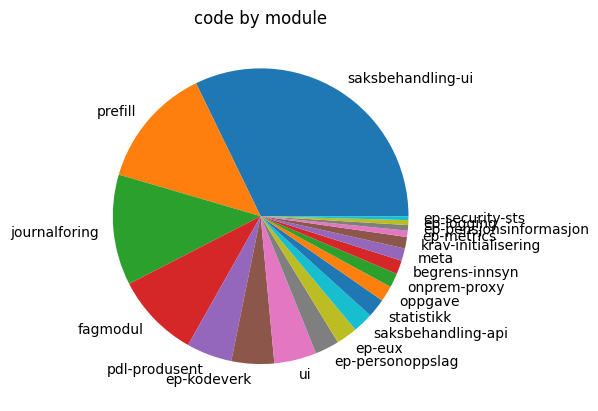

In [14]:
plot = df.plot.pie(y='code lines', legend=False, ylabel='', title="code by module")

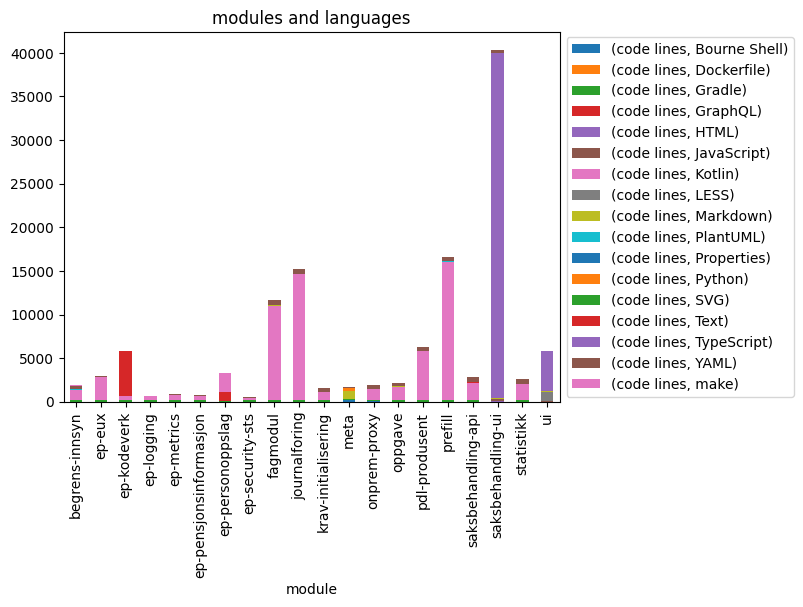

In [15]:
df = df_size[['module', 'language', 'code lines']]
df = df.groupby(['module', 'language']).sum().unstack()

plt = df.plot(kind='bar', stacked=True, title="modules and languages").legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

### Hva betyr dette?

Teamet har i dag én frontendutvikler
 på halv tid (som kom inn i teamet i sommer og den første tiden jobbet bare en dag i uken). Det tar tid å bygge opp kompetanse på en kodebase av denne størrelsen, og teamet er spesielt sårbart på frontend.

10-15% av koden er ikke i de to primære programmeringsspråkene (Kotlin og TypeScript). Dette gjenspeiler til dels at teamet også har hånd om bygg, deploy og applikasjonsdrift. (Koden for å lage underlag for denne rapporten er også en del av dette.)



## Kodeendringer <a class="anchor" id="kodeendringer"></a>

Vi kan se på hvilke app’er det er gjort kodeendringer i ved å sammenlikne koden på starten og slutten av tertialet.

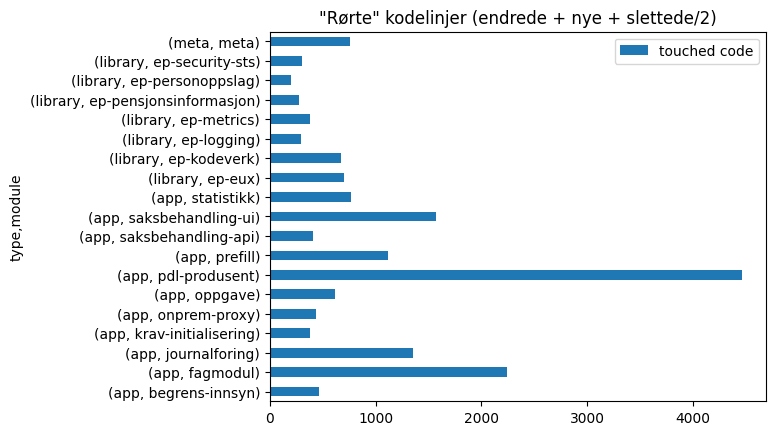

In [16]:

df = df_changes[['type', 'module', '!= code', '+ code', '- code']].copy()

df['touched code'] = df['!= code'] + df['+ code'] + (df['- code'] / 2).astype(int)

df = df[['type', 'module', 'touched code']]

plt = df.groupby(['type', 'module']).sum().sort_index(ascending=True).plot.barh(title='"Rørte" kodelinjer (endrede + nye + slettede/2)')

Vi ser at det er mest endring i kodelinjer i pdl-produsent, fagmodul og i frontenden for saksbehandlere.

Endringer i kodelinjer er en indikasjon, men den påvirkes av ting som reformattering av koden så det kan være vanskelig å si hva årsaken er.

### Hva betyr dette?

En komponent er ikke rørt i det hele tatt i tertialet («ui» innholder bibliotek for frontend). Vi ser at det vi har jobbet mest med pdl-produsent (adresser til PDL) og saksbehandling-ui (trygdetidtabell) også dukker opp i denne statistikken.

## Netto vekst i kodelinjer <a class="anchor" id="nettovekst"></a>

Netto vekst i kodelinjer indikerer at det blir mer kode å vedlikeholde. Refaktorering kan til en viss grad motvirke veksten.

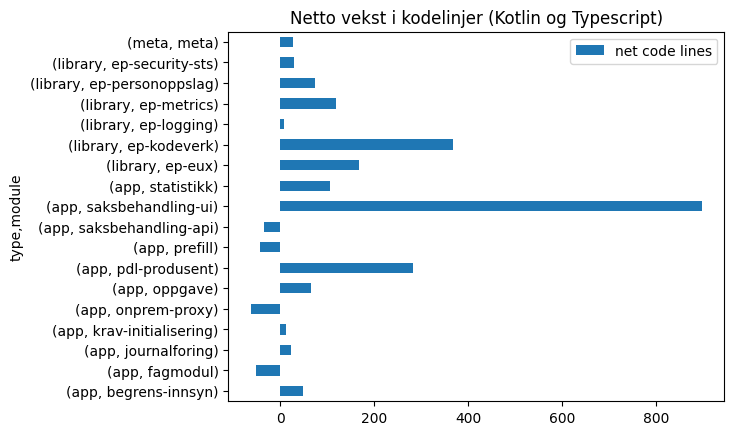

In [17]:
df = df_changes.loc[df_changes['language'].isin(['Kotlin', 'TypeScript'])].copy()

df['net code lines'] = df['+ code'] - df['- code']

df = df[['type', 'module', 'net code lines']]

plt = df.groupby(['type', 'module']).sum().sort_index(ascending=True).plot.barh(title='Netto vekst i kodelinjer (Kotlin og Typescript)')

### Hva betyr dette?

Dette viser at systemet øker i størrelse for språkene man stort sett bruker til å implementere tester og funksjonalitet. Det har tydeligvis også skjedd noe opprydning for noen moduler har minsket i størrelse, dette kan skyldes at kode er flyttet til bibliotek, eller annen opprydning. Mest sannsynlig har opprydning redusert størrelsen på koden i flere moduler, men tilveksten har spist opp gevinsten fra opprydningen.


## Detaljer i netto vekst i kodelinjer <a class="anchor" id="nettovekstdetaljer"></a>

In [18]:
df = df_changes[['module', 'language', '+ code', '- code']].copy()
df['net code lines'] = df['+ code'] - df['- code']
pivot = df.pivot(index='module', columns='language', values='net code lines')
pivot = pivot.fillna(0)
pivot.loc[:, 'Total']= pivot.sum(axis=1)
pivot = pivot.sort_values(['Total'], ascending=False)
pivot.loc['Total',:]= pivot.sum(axis=0)
pivot = pivot.astype(int)
pivot

language,Bourne Shell,Dockerfile,Gradle,HTML,Kotlin,Markdown,Properties,Python,Text,TypeScript,YAML,make,Total
module,,,,,,,,,,,,,
saksbehandling-ui,0,0,0,1,0,0,0,0,0,898,-103,0,796
meta,25,9,131,0,28,126,0,214,-3,0,75,6,611
ep-kodeverk,0,0,64,0,368,4,0,0,19,0,10,0,465
pdl-produsent,4,1,14,0,282,0,0,0,0,0,15,0,316
ep-eux,0,0,38,0,168,0,0,0,0,0,4,0,210
ep-metrics,0,0,45,0,119,0,0,0,0,0,14,0,178
statistikk,4,1,26,0,106,0,0,0,0,0,7,0,144
begrens-innsyn,4,1,24,0,49,0,0,0,0,0,10,0,88
ep-security-sts,0,0,35,0,30,0,0,0,0,0,6,0,71


Ved siden av økningen i kodelinjer med Kotlin og Typescript ser vi at det er mye økning i kodelinjer med gradle. (Dette er imidlertid ikke helt reelt fordi vi har omorganisert mye av gradle-koden basert på en mekanisme der vi endrer ett sted og så kopierer ut endringene til hver modul. Om vi teller de kopierte filene én gang så er det reelt sett en reduksjon i antall linjer med gradle-kode.)

Det er også lagt til en del Python-kode.

### Hva betyr dette?

Å bare se på produksjonskoden gir ikke hele bildet av hva systemet består av.
Teamet må beherske endringer også for andre språk/teknologier.
Statistikken kan gi et skjevt bilde av utviklingen av vedlikeholdsbehovet (som for gradle i dette tilfellet).

## Oppdatering av avhengigheter <a class="anchor" id="oppdateringavhengigheter"></a>

Oppdateringer av avhengigheter reduserer risiko for sikkerhetshull, og er med på å redusere problemene med sporadiske oppdateringer (mange ting som oppdateres samtidig, og at store hopp i versjoner gjør det vanskeligere å finne feil dersom noe går galt).

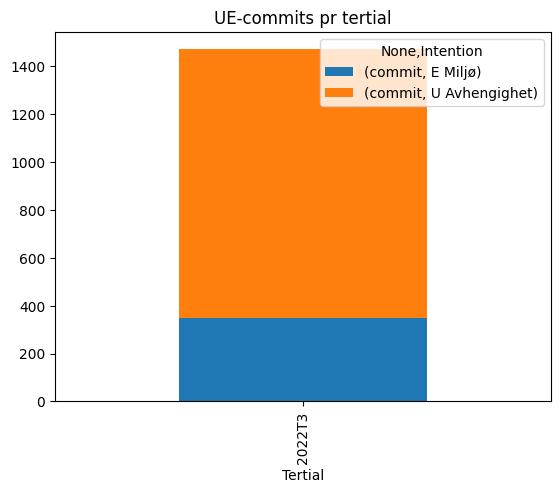

In [19]:
df = df_commits.loc[df_commits['UE']][['Tertial', 'Intention', 'commit']].loc[df_commits['Tertial'] == tertial]

df = df.groupby(['Tertial', 'Intention']).count().unstack()
fig = df.plot(kind='bar', stacked=True, title="UE-commits pr tertial")

Teamet har i 2022T3 gjort et stort antall oppdateringer på avhengigheter (i all hovedsak er dette oppdateringer til nye minor- og patch-versjoner).

Backend-modulene i systemet gjøres det jevnlig oppdateringer på, teamet forsøker å gjøre oppdateringer ukentlig («patch Tuesday»). Dette fører til mange oppdateringer, men jobben med oppdateringene er relativt liten – prosessen er støttet med script som gjør det enklere. Fremgangsmåten teamet benytter fører til at det blir mange små endringer (stort sett en endring pr avhengighet pr modul).

På frontend er det ikke noen fast rutine for dette, og det er også litt dårlig statistikk på dette fordi mekanismene og rutinene er forskjellige.

#### Oppdateringer av avhengigheter pr modul og måned

In [20]:
df = df_commits.loc[df_commits['Tertial'] == tertial].loc[df_commits['intention'] == 'U'][['Måned', 'type', 'module', 'commit']]

pivot = df.groupby(['type', 'module', 'Måned']).count().unstack().fillna(0).astype(int)

pivot.loc[:, 'Total'] = pivot.sum(axis=1)
pivot = pivot.sort_values(['type','Total'], ascending=[True,False])
pivot

commit                         Total
Måned                          2022-09 2022-10 2022-11 2022-12      
type    module                                                      
app     pdl-produsent               25      46      30      31   132
        fagmodul                    29      27      32      36   124
        prefill                     30      24      33      37   124
        journalforing               21      18      26      24    89
        begrens-innsyn              21      15      23      27    86
        onprem-proxy                21      14      25      24    84
        saksbehandling-api          21      15      26      19    81
        statistikk                  20      13      23      22    78
        krav-initialisering         16      13      19      12    60
        oppgave                     15       9      16      14    54
        saksbehandling-ui            1       1       0       0     2
library ep-kodeverk                 14      10      16      13    53
        ep-pensjonsinformasjon      14       4      13       6    37
        ep-security-sts             11       4      14       5    34
        ep-personoppslag             7       5       3       9    24
        ep-eux                       6       1       7       4    18
        ep-logging                   5       3       6       4    18
        ep-metrics                   5       1       5       5    16
meta    meta                         0       1       3       1     5

### Hva betyr dette?

For backend-modulene ser det ut til at det er jevnlig oppdatering, for frontend-app’en saksbehandling-ui bør det nok ses nærmere på hvorfor det telles så få oppdateringer av avhengigheter.

## Løpende endringer i systemet <a class="anchor" id="løpendeendringer"></a>

At det gjøres endringer i systemet er indikator på at systemet vedlikeholdes, noe som opprettholder kjennskapen til systemet. Vi ser her på endringer merket med B, D, F, R og T; de er knyttet til feilretting (B), dokumentasjon (nær/i koden) (D), funksjonalitet (F), interne forbedringer/refaktorering (R) og testforbedringer (T).

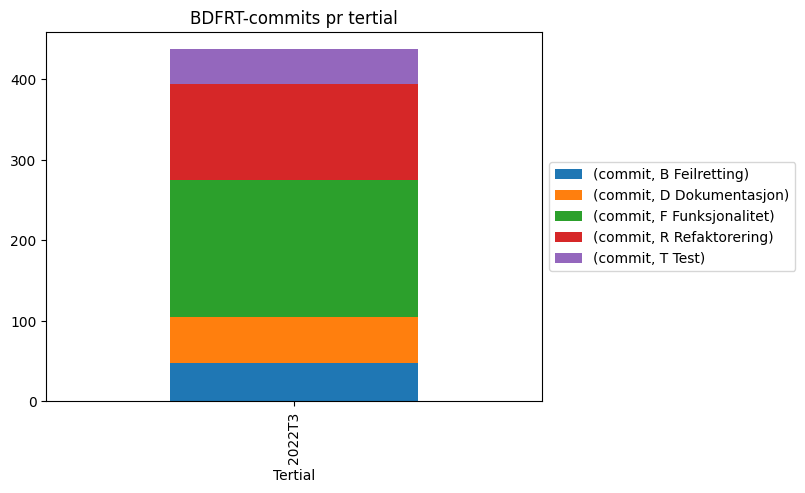

In [21]:
df = df_commits.loc[df_commits['BDFRT']][['Tertial', 'Intention', 'commit']].loc[df_commits['Tertial'] == tertial]

df = df.groupby(['Tertial', 'Intention']).count().unstack()
fig = df.plot(kind='bar', stacked=True, title="BDFRT-commits pr tertial").legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

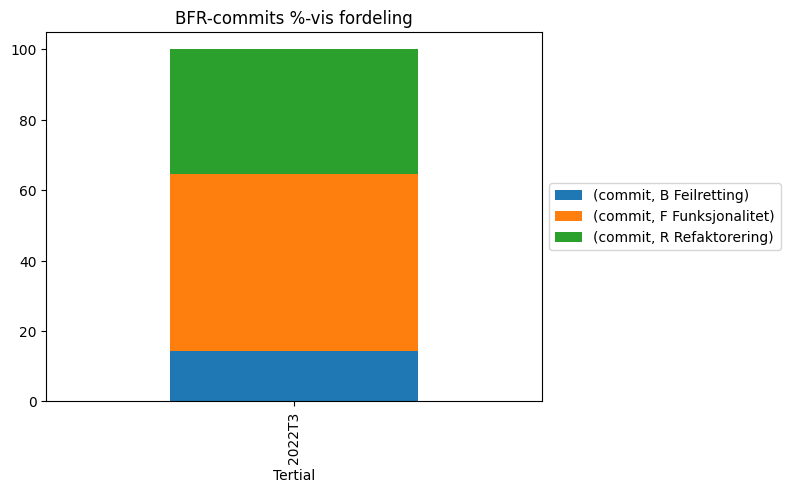

In [22]:
df = df_commits.loc[df_commits['intention'].isin(['B','F','R'])][['Tertial', 'Intention', 'commit']].loc[df_commits['Tertial'] == tertial]

df = df.groupby(['Tertial', 'Intention']).count().unstack()

df_total = df.sum(axis=1)
df_rel = df.div(df_total, 0)*100

fig = df_rel.plot(kind='bar', stacked=True, title="BFR-commits %-vis fordeling").legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Om vi snevrer inn til feilrettings-, refaktorerings- og funksjonalitetsrelaterte endringer så ser vi at feilretting utgjør litt over en tidel av disse endringene, og refaktorering en drøy tredel.

Feilrettingsendringer (B) er ikke nødvendigvis knyttet til feil som har truffet produksjon, men av disse endringene er knyttet til det. Ellers er feilene som regel nyoppdaget (vi prøver å ta unna når vi oppdager dem), men det er ikke lett å si om de er gamle eller innført nylig.

Endringene er merket refaktorering (R) er endringer som gjøres for å forbedre den interne kvaliteten, og ikke minst for at koden (som ofte er skrevet av noen andre) skal bli lettere å forstå for den som jobber med den i øyeblikket, eller i fremtiden. Sannsynligvis vil det gjøre systemet enklere å endre neste gang, med mindre risiko for feil og bittelitt mindre innsats. Dersom andelen refaktoreringsendringer faller er det viktig å undersøke hva som skjer.

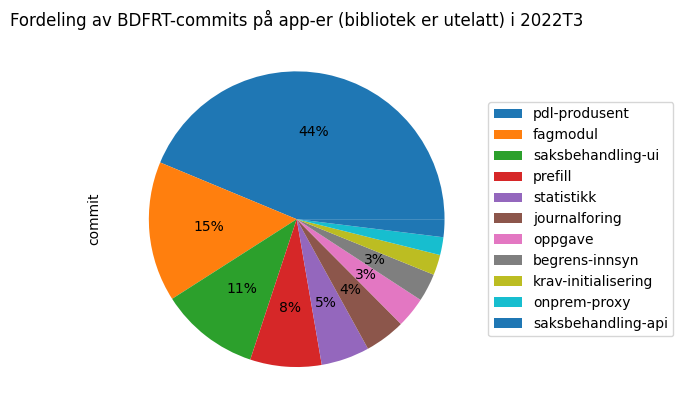

In [23]:
df = df_commits.loc[df_commits['BDFRT']].loc[df_commits['Tertial'] == tertial].loc[df_commits['type']=='app'][['module', 'commit']]

df = df.groupby('module').count().sort_values(by='commit', ascending=False)

def autopct(pct):
    return ('%.0f' % pct + '%') if pct > 3 else ''

plt = df.plot.pie(
    y='commit',
    title=f'Fordeling av BDFRT-commits på app-er (bibliotek er utelatt) i {tertial}',
    autopct=autopct, labeldistance=None).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


I 2022T3 er det gjort flest endringer på pdl-produsent.

Dette er i stor grad knyttet til at det er implementert automatisk oppdatering av utenlandske kontaktadresser i PDL. Funksjonaliteten som er bygget i pdl-produsent er middels komplisert, men avgrenset i omfang.

Det er gjort lite arbeid på flere viktige moduler, spesielt gjelder det journalføring og oppgave-modulen (mens prefill og fagmodul som er to andre viktige komponenter, har noe endringer).

#### BDFRT-oppdateringer pr modul

In [24]:
df = df_commits.loc[df_commits['BDFRT']].loc[df_commits['Tertial'] == tertial][['type', 'module', 'intention', 'commit']]

df = df.groupby(['type', 'module', 'intention']).count().unstack()
df['Total'] = df.sum(axis=1)

df = df.fillna(0).astype(int).sort_values(by=['type', 'Total'], ascending=[True, False])
df

commit                 Total
intention                           B   D   F   R   T      
type    module                                             
app     pdl-produsent              13   4  59  52  29   157
        fagmodul                    3   6  18  25   3    55
        saksbehandling-ui          13   1  11  12   2    39
        prefill                     0   1  14   9   4    28
        statistikk                  7   5   5   2   0    19
        journalforing               1   1  11   2   1    16
        oppgave                     0   3   6   2   1    12
        begrens-innsyn              2   2   7   0   0    11
        krav-initialisering         0   3   4   1   0     8
        onprem-proxy                0   1   5   1   0     7
        saksbehandling-api          0   1   3   2   1     7
library ep-eux                      7   1   9   4   1    22
        ep-kodeverk                 2   2   8   4   0    16
        ep-metrics                  0   2   3   2   1     8
        ep-personoppslag            0   1   4   0   0     5
        ep-logging                  0   1   1   0   0     2
        ep-security-sts             0   1   1   0   0     2
        ep-pensjonsinformasjon      0   1   0   0   0     1
        ui                          0   1   0   0   0     1
meta    meta                        0  19   1   1   0    21

Vi ser at det er mest feilretting (B) på pdl-produsent og saksbehandling-ui.

### Hva betyr dette?

Kunnskapen om pdl-produsent er god etter nylig arbeid på den, og vi ser at de tre viktige modulene saksbehandling-ui, fagmodul og prefill er gjort litt på, mens to andre viktige moduler (journalføring og oppgave) er gjort lite arbeid på, noe som er bekymringsfullt med tanke på forvitring av kompetansen på disse.

De øvrige modulene med relativt lite endringer er litt mindre bekymringsfulle siden de er relativt små og enkle.

De feil-relaterte endringene på pdl-produsent og saksbehandling-ui har trolig ulike årsaker. For pdl-produsent handler det trolig om at det har blitt gjort mye endringer – og endringer korrelerer gjerne med at det introduseres – eller oppdages – feil. For saksbehandling-ui kan det kanskje også handle om at det er feil som ikke er nye, men at man der har lite (og har hatt enda mindre) kapasitet så feil har fått samle seg opp før de har blitt rettet



## Risiko <a class="anchor" id="risiko"></a>

Vi merker commits med risiko, med en skala fra 0 til 5:

0)	Ingen risiko
1)	Kjent trygg
2)	Validert
3)	Kjent restrisiko
4)	Feil/sannsynlig feil
5)	Ukjent risiko

Endringer med risiko 1 Kjent trygg har svært lav risiko og krever lite eller ingen kjøring av tester. Dokumentasjons- og testendringer skal ha risiko 1. For endringer i produksjonskode er det strenge regler for hvilke endringer som kan merkes risiko 1 – stort sett går det ut på at det er små endringer som er gjort med støtte av funksjonalitet i utviklingsverktøyet (IDE).

Endringer med risiko 2 Validert krever som regel at tester kjøres lokalt for at man skal bli trygg, noe som kan ta litt tid, avhengig av app og oppsett. For oppdateringer av avhengigheter er det ofte vanskelig å si hva risiko er, men vi kjører tester for alle oppdateringer så vi merker dem rutinemessig med risiko 2.

Endringer med risiko 3 Kjent restrisiko må ofte følges opp litt ekstra i forbindelse med produksjonssetting, eller de må testes manuelt før de går i produksjon.

Risiko 4 er normalt ikke akseptabelt å dytte til produksjon – dette er endringer som er uferdige eller har høy risiko.

Risiko 5 betyr at risiko er ukjent. Ofte vet man mer i situasjonen, men kunnskapen om risiko er tapt i ettertid (må eventuelt vurderes på nytt).

Det er nok litt mer slurv med vurdering av risikonivå enn det er med vurdering av intensjon.

De fleste endringer i produksjonskode vil være risiko fra 1 til 3

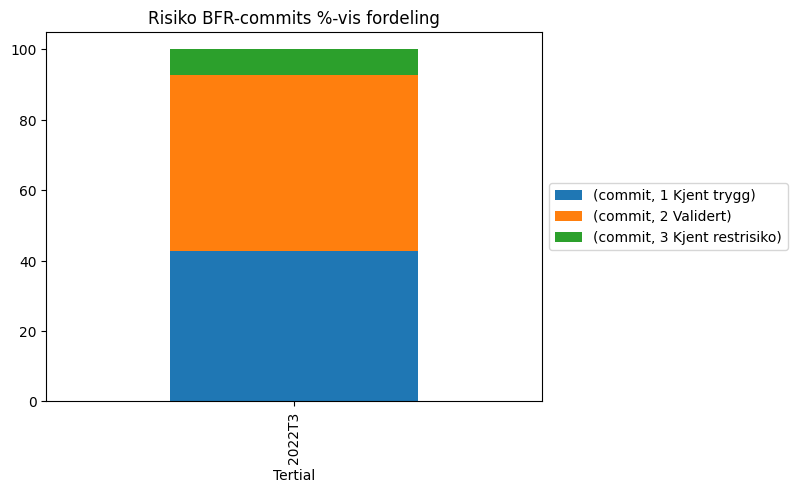

In [25]:
df = df_commits.loc[df_commits['intention'].isin(['B','F','R'])].loc[df_commits['Tertial'] == tertial][['Tertial', 'Risk', 'commit']]

df = df.groupby(['Tertial', 'Risk']).count().unstack()

df_total = df.sum(axis=1)
df_rel = df.div(df_total, 0)*100

fig = df_rel.plot(kind='bar', stacked=True, title="Risiko BFR-commits %-vis fordeling").legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

De kjent trygge endringene utgjør ca 40%. For commits som typisk endrer produksjonskode ser vi at andelen med kjent restrisiko er under 10%.

### Hva betyr dette?

Få endringer med restrisiko er bra – det betyr mindre jobb med å følge opp endringen på vei ut i produksjon. Kjent trygge endringer er ofte endringer som bedrer lesbarhet og struktur i koden, at det er på 40% betyr trolig at det er mange små forbedringer.


# Konklusjoner <a class="anchor" id="konklusjoner"></a>

In [26]:
! pip install pyppeteer 2>&1 1>/dev/null
# jupyter nbconvert "Utviklingsstatistikk.ipynb" --to webpdf --TemplateExporter.exclude_input=True --allow-chromium-download
